In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#locate the data
!ls "../content/drive/My Drive/ColabNotebooks"

'heart (1).gsheet'   heart.csv	 Heart-Disease-Prediction.ipynb   heart.gsheet


## Exploratory Data Analysis
Let's look what does this data looks like.

In [ ]:
df = pd.read_csv("../content/drive/My Drive/ColabNotebooks/heart.csv")
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.shape

(303, 14)

In [ ]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [ ]:
df.drop_duplicates()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Text(0.5, 1.0, 'Heart Disease')

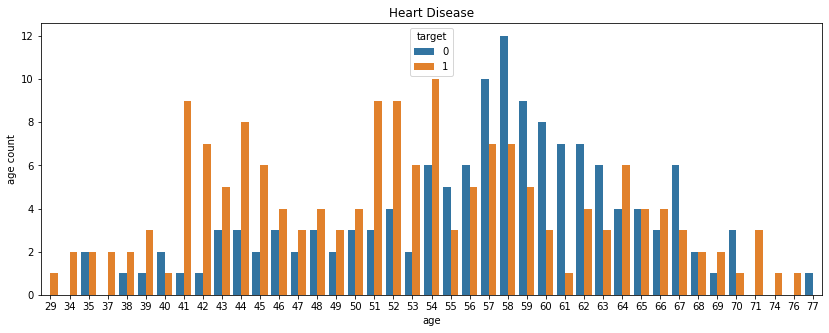

In [ ]:
plt.figure(figsize=(14, 5))
sns.countplot(x ='age', hue='target', data = df)
plt.ylabel("age count")
plt.title("Heart Disease")


## Features Engineering

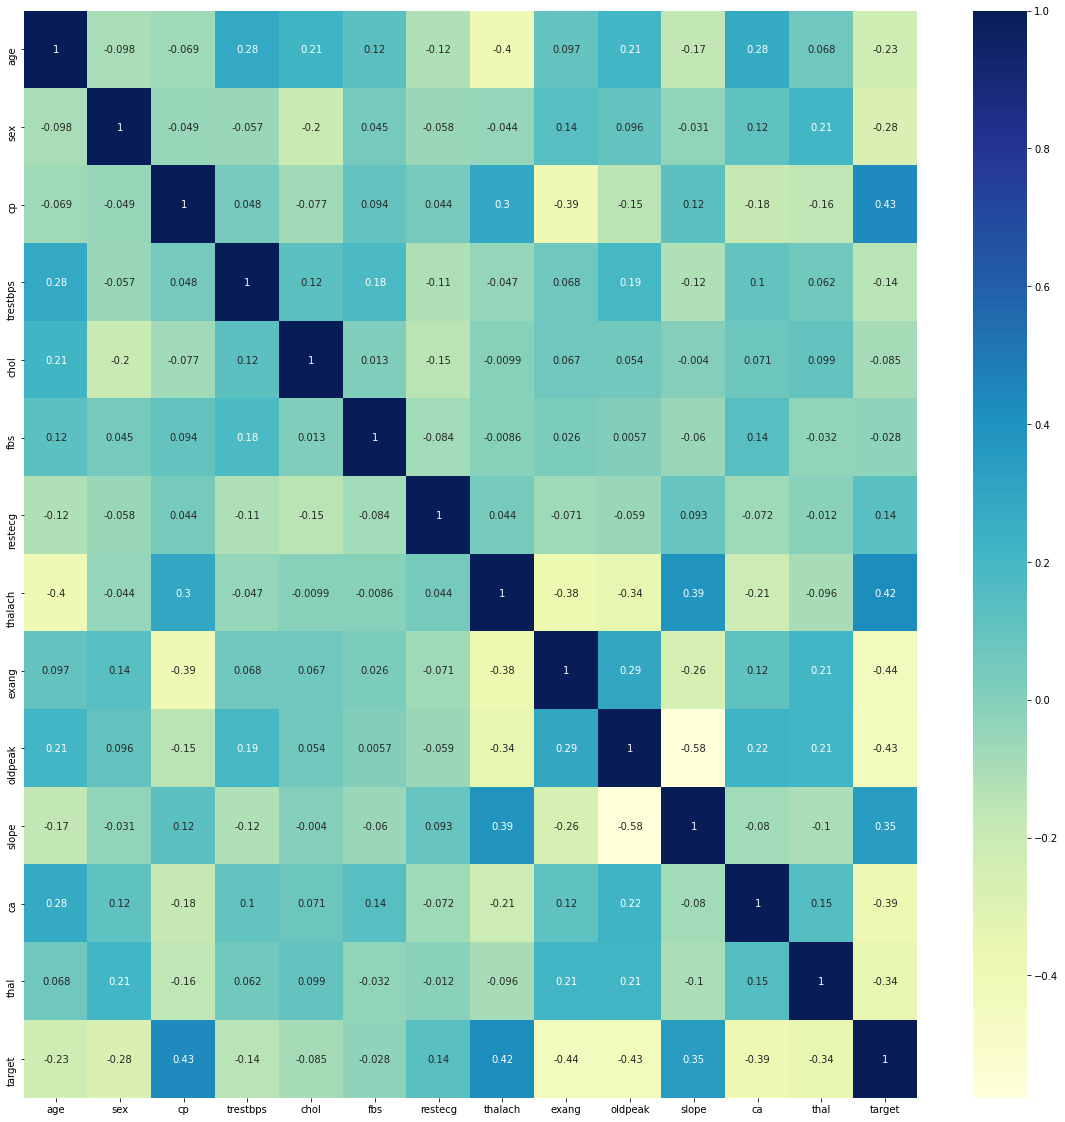

In [ ]:
# find correlation
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True ,cmap = 'YlGnBu')
plt.show()

In [ ]:
#Correlation with output variable
cor_matrix = df.corr().abs()
cor_target = abs(cor_matrix["target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

cp         0.433798
thalach    0.421741
exang      0.436757
oldpeak    0.430696
target     1.000000
Name: target, dtype: float64

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const       4.986501e-03
age         7.611292e-01
sex         4.244938e-05
cp          8.401461e-07
trestbps    1.144073e-01
chol        4.025451e-01
fbs         7.711245e-01
restecg     2.128192e-01
thalach     7.988188e-03
exang       5.386779e-03
oldpeak     1.084749e-02
slope       6.345322e-02
ca          6.248649e-06
thal        9.523132e-04
dtype: float64

In [ ]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [ ]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False False False  True  True  True  True
  True]
[6 1 1 5 7 4 2 3 1 1 1 1 1]


In [ ]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.435197


In [ ]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 11)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['sex', 'cp', 'trestbps', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


In [ ]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.004803
Best score using built-in LassoCV: 0.516022


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

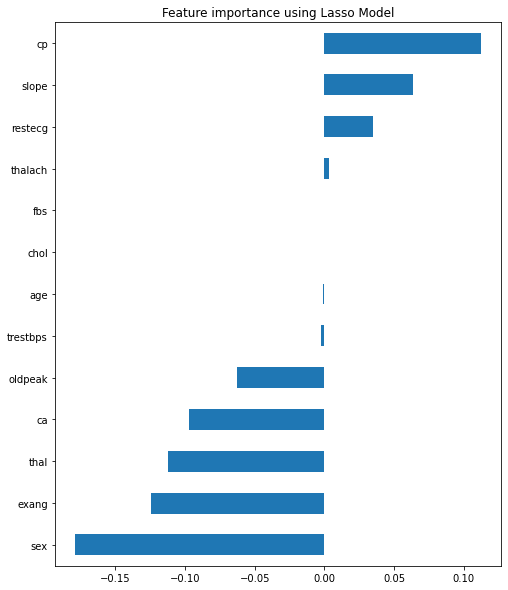

In [ ]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Feature: 0, Score: 0.00581
Feature: 1, Score: 0.00397
Feature: 2, Score: 0.00577
Feature: 3, Score: 0.18202
Feature: 4, Score: 0.00401
Feature: 5, Score: 0.51906
Feature: 6, Score: 0.00631
Feature: 7, Score: 0.06806
Feature: 8, Score: 0.00912
Feature: 9, Score: 0.00396
Feature: 10, Score: 0.05351
Feature: 11, Score: 0.00530
Feature: 12, Score: 0.13061
Feature: 13, Score: 0.00249


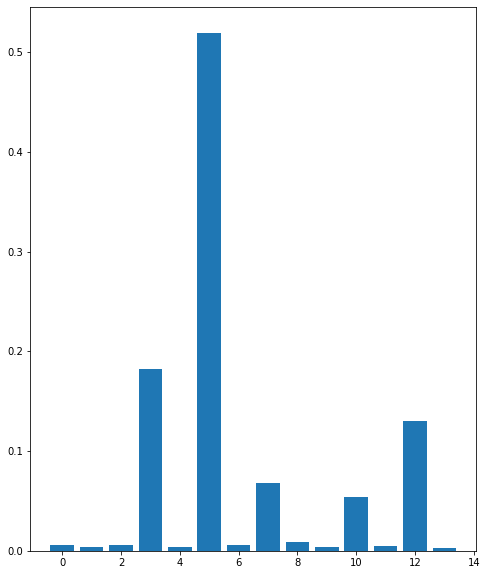

In [ ]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=14, n_informative=5, random_state=1)
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Split train and test set

In [ ]:
df.drop(df.columns.difference(['sex', 'cp', 'exang', 'oldpeak', 'ca', 'thal', 'target']), 1, inplace=True)

In [ ]:
df.head()

,sex,cp,exang,oldpeak,ca,thal,target
0,1,3,0,2.3,0,1,1
1,1,2,0,3.5,0,2,1
2,0,1,0,1.4,0,2,1
3,1,1,0,0.8,0,2,1
4,0,0,1,0.6,0,2,1


In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
df.target.unique()

array([1, 0])

In [ ]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

## Machine Learning

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
test_size = 0.38
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)


In [ ]:
# fit model no training data
model = XGBClassifier(n_estimators=300, learning_rate=0.001, random_state=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.66%


In [ ]:
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        53
           1       0.90      0.90      0.90        63

    accuracy                           0.90       116
   macro avg       0.90      0.90      0.90       116
weighted avg       0.90      0.90      0.90       116



In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[47  6]
 [ 6 57]]


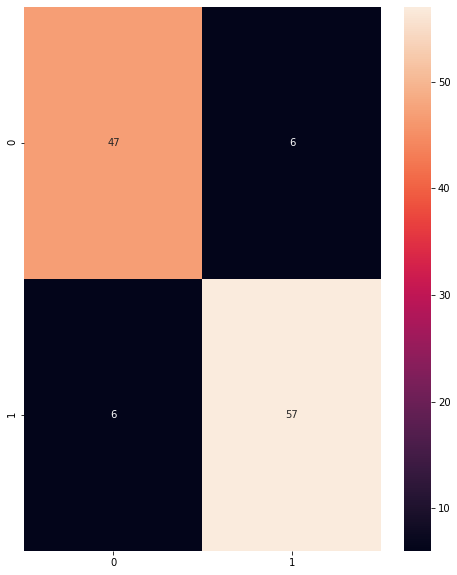

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
df2 = pd.DataFrame(X_test)
df2 = df2.rename(columns={
              0: 'sex', 
              1: 'cp', 
              2: 'exang', 
              3:'oldpeak', 
              4: 'ca', 
              5: 'thal',
})
df2['true'] = y_test
df2['predicted'] = y_pred
df2.to_csv('Predicted.csv')

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8362068965517241


In [ ]:
#Import svm model
from sklearn.neighbors import KNeighborsClassifier

#Create a svm Classifier
model = KNeighborsClassifier(n_neighbors=7) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8362068965517241
